<h1>Experimentos de Topologia</h1>
<p>Experimentos realizados com o objetivo de encontrar uma topologia para uma rede neural convolucional que seja capaz de aprender o procedimento de <b>esteganografia</b>, ou seja, escoder e revelar um arquivo binário em uma imagem digital.</p>

<h3>Importação de bibliotecas</h3>

In [1]:
import os

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import random
import math
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from skimage.metrics import mean_squared_error
from skimage.io import imshow, imread, imsave
from tqdm.notebook import tqdm, trange
import time
import string

from IPython import display

<h3>Definição da semente do gerador de números aleatórios para permitir a reprodução dos experimentos realizados</h3>

In [3]:
os.environ['PYTHONHASHSEED']=str(456)
np.random.seed(456)
random.seed(456)

<h3>Declaração de funções para armazenar/recuperar um arquivo binário no ruído de uma imagem</h3>

In [4]:
# função responsável por definir quais pontos da imagem conterá o ruído da mensagem secreta
def generateMatStegano():
    mat = np.zeros((64, 64))
    
    for i in range(64):
        randIdxs = random.sample(range(0, 64), 21)
        
        for j in range(64):
            if j in randIdxs:
                mat[i][j] = 1
            
    return mat

matStegano = generateMatStegano()

In [5]:
# Função responsável por adicionar na imagem um ruído representando a mensagem secreta
def stegano(img, msg):
    retImg = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
    
    z = 0
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                retImg[i][j][k] = img[i][j][k]

                if matStegano[i][j] == 1:
                    if msg[z] == 0:
                        retImg[i][j][k] = 0
                    else:
                        retImg[i][j][k] = 255
            
            if matStegano[i][j] == 1:
                z += 1
    
    return retImg

In [6]:
# Função responsável por extrair a mensagem secreta do ruído da imagem
def steganoInv(img):
    msg = []
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if matStegano[i][j] == 1:
              media = 0

              for k in range(img.shape[2]):
                media += img[i][j][k]

              media /= img.shape[2]

              if media >= 127:
                  msg.append(1)
              else:
                  msg.append(0)
    
    msg = np.array(msg)
    
    return msg

<h3>Leitura e pré-processamento do dataset</h3>

In [7]:
images = []

for file in os.listdir('dataset'):
    try:
        img = imread('dataset/' + file)

        if img.shape == (64, 64, 3):
          images.append(img)
    except:
        continue

images = np.array(images)

In [8]:
images.shape

(9811, 64, 64, 3)

In [9]:
n = images.shape[0]

In [10]:
train_images, test_images = images[:int(n*0.75)], images[int(n*0.75):]

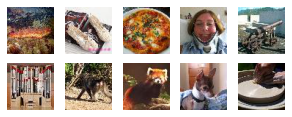

In [11]:
fig = plt.figure(figsize=(5, 5))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i], cmap='gray')
  plt.axis('off')
plt.savefig('dataset_tiny_example.png')
plt.show()

In [12]:
train_images_original = np.array(train_images, copy=True)
test_images_original = np.array(test_images, copy=True)

In [13]:
train_images.shape

(7358, 64, 64, 3)

<h3>Geração das mensagens secretas, aplicação do código de haming para aumentar a redundancia e armazenamento da mensagem secreta nos arquivos do dataset</h3>

In [14]:
def neededRedundantBits(m):
  for r in range(m + 1):
    if 2 ** r >= m + r + 1:
      return r
  return 0

In [15]:
tot = 1344

secretLength = 0

for i in range(tot + 1):
  if i + neededRedundantBits(i) == tot:
    secretLength = i
    break

print(tot, secretLength)

1344 1333


In [16]:
nHammer = tot - secretLength

In [17]:
# Função responsável por codificar a mensagem utilizando codificação de hammer
def preparaHammerArray(mensagem, nHammerBits):
  retorno = []

  j = 0
  k = 0

  for i in range(1, len(mensagem) + nHammerBits + 1):
    if i == 2 ** j:
      retorno.append(0)
      j += 1
    else:
      retorno.append(mensagem[k])
      k += 1

  for i in range(nHammerBits):
    x = 0

    for j in range(1, len(retorno) + 1):
      if j & (1 << i) == 1 << i:
        x ^= retorno[j-1]
    
    retorno[(1<<i) - 1] = x

  return retorno

In [18]:
# Função responsável por decodificar a mensagem utilizando codificação de hammer
def corrigeHammerArray(mensagem, nHammerBits):
  retorno = []

  j = 0

  for i in range(1, len(mensagem) + 1):
    if i == 2 ** j:
      retorno.append(0)
      j += 1
    else:
      retorno.append(mensagem[i - 1])

  for i in range(nHammerBits):
    x = 0

    for j in range(1, len(retorno) + 1):
      if j & (1 << i) == 1 << i:
        x ^= retorno[j-1]
    
    retorno[(1<<i) - 1] = x

  vet = ""

  for i in range(nHammerBits):
    vet += str(mensagem[(1<<i) - 1] ^ retorno[(1<<i) - 1])

  r = int(vet[::-1], 2)

  return r

In [19]:
preparaHammerArray([1, 1, 1, 1], 3)

[1, 1, 1, 1, 1, 1, 1]

In [20]:
corrigeHammerArray([1, 1, 1, 1, 1, 1, 1], 3)

0

In [21]:
# Função responsavél po gerar uma sequencia de bits que representa uma string aleatória, simulando a sequencia de bits de arquivos .txt
def generateStrBin(secretSize):
  message = []
  
  nChar = secretSize // 8

  randomStr = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(nChar))

  for i in randomStr:
    k = ord(i)
    for j in range(8):
      message.append(k & 1)
      k >>= 1

  while(len(message) < secretSize):
    message.append(0)

  return message

In [22]:
# armazena as mensagens secretas no dataset de treino
train_images2 = train_images
shape = train_images2.shape
train_images = np.zeros((shape[0], shape[1], shape[2], shape[3])).astype('int')

train_messages = [];

for i in trange(train_images2.shape[0]):
    message = generateStrBin(secretLength)

    message = preparaHammerArray(message, nHammer)
        
    train_messages.append(message)
    
    train_images[i] = stegano(train_images2[i], message).astype('int')
    
train_messages = np.array(train_messages)

  0%|          | 0/7358 [00:00<?, ?it/s]

In [23]:
# armazena as mensagens secretas no dataset de teste
test_images2 = test_images
shape = test_images2.shape
test_images = np.zeros((shape[0], shape[1], shape[2], shape[3])).astype('int')

test_messages = [];

for i in trange(test_images2.shape[0]):
    message = generateStrBin(secretLength)

    message = preparaHammerArray(message, nHammer)
        
    test_messages.append(message)
    
    test_images[i] = stegano(test_images2[i], message)
    
test_messages = np.array(test_messages)

  0%|          | 0/2453 [00:00<?, ?it/s]

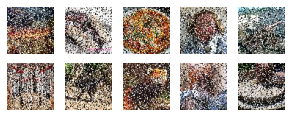

In [24]:
fig = plt.figure(figsize=(5, 5))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i], cmap='gray')
  plt.axis('off')
plt.savefig('dataset_tiny_noisy.png')
plt.show()

In [25]:
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images_original = train_images_original.astype('float32') / 255.
test_images_original = test_images_original.astype('float32') / 255.

print (train_images.shape)
print (test_images.shape)
print (train_images_original.shape)
print (test_images_original.shape)

(7358, 64, 64, 3)
(2453, 64, 64, 3)
(7358, 64, 64, 3)
(2453, 64, 64, 3)


<h3>Definição das topologias a serem testadas para o encoder e decoder</h3>

In [26]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [27]:
encoder = []

for j in range(1, 6):
  inputLayer = layers.Input(shape=(64, 64, 3))

  x = inputLayer

  for k in range(j):
    x = layers.Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid' + str(k) + '_3x3')(x)
  
  outputLayer = layers.Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='sigmoid', name='output_C')(x)

  model = Model(inputs=inputLayer, outputs=outputLayer, name = 'Encoder')

  encoder.append(model)

In [28]:
encoder[0].summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv_hid0_3x3 (Conv2D)      (None, 64, 64, 50)        1400      
                                                                 
 output_C (Conv2D)           (None, 64, 64, 3)         1353      
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [29]:
decoder = []

for j in range(1, 6):
  inputLayer = layers.Input(shape=(64, 64, 3))

  x = inputLayer

  for k in range(j):
    x = layers.Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev' + str(k) + '_3x3')(x)

  outputLayer = layers.Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='sigmoid', name='output_S')(x)

  model = Model(inputs=inputLayer, outputs=outputLayer, name = 'Decoder')

  decoder.append(model)

In [30]:
decoder[0].summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv_rev0_3x3 (Conv2D)      (None, 64, 64, 50)        1400      
                                                                 
 output_S (Conv2D)           (None, 64, 64, 3)         1353      
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [31]:
i = 0
for model in encoder:
  tf.keras.utils.plot_model(model, to_file='model_encoder_' + str(i) + '.png', show_shapes=True)
  i += 1

In [32]:
i = 0
for model in decoder:
  tf.keras.utils.plot_model(model, to_file='model_decoder_' + str(i) + '.png', show_shapes=True)
  i += 1

In [33]:
len(encoder)

5

In [34]:
len(decoder)

5

<h3>Treinamento da rede neural convolucional encoder</h3>

In [35]:
encoder_optimizer = []

for i in encoder:
  encoder_optimizer.append(tf.keras.optimizers.Adam())

In [36]:
decoder_optimizer = []

for i in decoder:
  decoder_optimizer.append(tf.keras.optimizers.Adam())

In [37]:
history = []

for i in range(len(encoder)):
  encoder[i].compile(optimizer='adam', loss=losses.MeanSquaredError())
  hist = encoder[i].fit(train_images, train_images_original,
                  epochs=20,
                  shuffle=False,
                  validation_data=(test_images, test_images_original))
  history.append(hist)

Epoch 1/20
230/230 [==============================] - 13s 10ms/step - loss: 0.0333 - val_loss: 0.0196
Epoch 2/20
230/230 [==============================] - 2s 9ms/step - loss: 0.0188 - val_loss: 0.0186
Epoch 3/20
230/230 [==============================] - 2s 8ms/step - loss: 0.0181 - val_loss: 0.0179
Epoch 4/20
230/230 [==============================] - 2s 8ms/step - loss: 0.0173 - val_loss: 0.0171
Epoch 5/20
230/230 [==============================] - 2s 8ms/step - loss: 0.0164 - val_loss: 0.0160
Epoch 6/20
230/230 [==============================] - 2s 9ms/step - loss: 0.0153 - val_loss: 0.0150
Epoch 7/20
230/230 [==============================] - 2s 9ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 8/20
230/230 [==============================] - 2s 8ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 9/20
230/230 [==============================] - 2s 8ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 10/20
230/230 [==============================] - 2s 8ms/step - loss: 0.0126 - val_loss: 0.01

In [38]:
print(history[0].history.keys())

dict_keys(['loss', 'val_loss'])


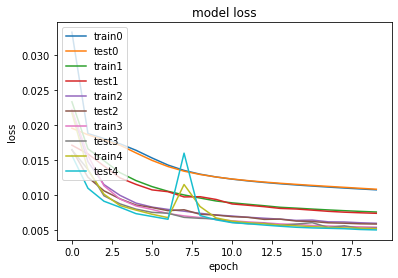

In [39]:
legend = []

i = 0

for hist in history:
  plt.plot(hist.history['loss'])
  legend.append('train' + str(i))

  plt.plot(hist.history['val_loss'])
  legend.append('test' + str(i))

  i += 1

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.savefig('first_training.png')
plt.show()

<h3>Treinamento adversarial das redes neurais convolucionais encoder e decoder</h3>

In [40]:
EPOCHS = 20
BATCH_SIZE = 32

In [41]:
mseFun = losses.MeanSquaredError()

In [42]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images, originalImages, enc, dec, enc_opt, dec_opt):
    with tf.GradientTape() as encoder_tape, tf.GradientTape() as decoder_tape:
      encoded_images = enc(images, training=True)
      decoded_images = dec(encoded_images, training=True)

      encoded_loss = mseFun(originalImages, encoded_images)
      decoded_loss = mseFun(images, decoded_images)
      total_loss = encoded_loss + decoded_loss

    gradients_of_encoder = encoder_tape.gradient(total_loss, enc.trainable_variables)
    gradients_of_decoder = decoder_tape.gradient(decoded_loss, dec.trainable_variables)

    enc_opt.apply_gradients(zip(gradients_of_encoder, enc.trainable_variables))
    dec_opt.apply_gradients(zip(gradients_of_decoder, dec.trainable_variables))

    return total_loss

In [43]:
def train(dataset, datasetTest, epochs, enc, dec, enc_opt, dec_opt):
  lossVet = []
  lossTestVet = []

  for epoch in trange(epochs):
    start = time.time()

    lenDataset = dataset.shape[0]
    nBatches = math.floor(lenDataset / BATCH_SIZE)

    total_loss = 0

    for i in trange(nBatches):
      total_loss += train_step(dataset[i:i + BATCH_SIZE], train_images_original[i:i + BATCH_SIZE], enc, dec, enc_opt, dec_opt)
    
    total_loss /= nBatches

    lossVet.append(total_loss)

    encoded_images_test = enc(datasetTest, training=False)
    decoded_images_test = dec(encoded_images_test, training=False)

    encoded_loss_test = mseFun(test_images_original, encoded_images_test)
    decoded_loss_test = mseFun(datasetTest, decoded_images_test)
    total_loss_test = encoded_loss_test + decoded_loss_test

    lossTestVet.append(total_loss_test)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return lossVet, lossTestVet

In [44]:
train_images_original.shape

(7358, 64, 64, 3)

In [45]:
history = []
historyTest = []

for i in range(len(encoder)):
  hist, histTest = train(train_images, test_images, EPOCHS, encoder[i], decoder[i], encoder_optimizer[i], decoder_optimizer[i])
  history.append(hist)
  historyTest.append(histTest)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 1 is 7.202683448791504 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 2 is 6.2834084033966064 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 3 is 6.083898544311523 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 4 is 6.281712293624878 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 5 is 6.255121469497681 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 6 is 6.1463847160339355 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 7 is 6.218254566192627 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 8 is 6.294589281082153 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 9 is 6.264225482940674 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 10 is 6.268515586853027 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 11 is 6.132392883300781 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 12 is 6.3580756187438965 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 13 is 6.1294238567352295 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 14 is 6.328766822814941 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 15 is 6.292580842971802 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 16 is 6.242475986480713 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 17 is 6.340150833129883 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 18 is 6.127485036849976 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 19 is 6.340519189834595 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 20 is 6.355575323104858 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 1 is 11.396154642105103 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 2 is 9.531069993972778 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 3 is 9.487508535385132 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 4 is 9.544408559799194 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 5 is 9.453347444534302 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 6 is 9.547424554824829 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 7 is 9.556480884552002 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 8 is 9.570753335952759 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 9 is 9.529612302780151 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 10 is 9.540952444076538 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 11 is 9.537090539932251 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 12 is 9.478566408157349 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 13 is 9.58887529373169 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 14 is 9.470589637756348 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 15 is 9.537424087524414 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 16 is 9.522082567214966 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 17 is 9.553466558456421 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 18 is 9.55782699584961 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 19 is 9.568630456924438 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 20 is 9.569989919662476 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 1 is 13.124334335327148 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 2 is 13.084777116775513 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 3 is 13.069048166275024 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 4 is 13.136281728744507 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 5 is 13.129328727722168 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 6 is 13.171934366226196 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 7 is 13.37545394897461 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 8 is 13.177695035934448 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 9 is 13.175756454467773 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 10 is 13.235512495040894 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 11 is 13.188786506652832 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 12 is 13.193277359008789 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 13 is 13.200748920440674 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 14 is 13.193599700927734 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 15 is 13.160816431045532 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 16 is 13.255216598510742 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 17 is 13.117553234100342 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 18 is 13.178046941757202 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 19 is 13.224654912948608 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 20 is 13.197829246520996 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 1 is 16.557019472122192 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 2 is 16.441107034683228 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 3 is 16.5862295627594 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 4 is 16.536784410476685 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 5 is 16.518317699432373 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 6 is 16.465004920959473 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 7 is 16.500608682632446 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 8 is 16.576359272003174 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 9 is 16.52857208251953 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 10 is 16.5074200630188 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 11 is 16.560281991958618 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 12 is 16.35866904258728 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 13 is 16.557731866836548 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 14 is 16.522032022476196 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 15 is 16.582845449447632 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 16 is 16.535569190979004 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 17 is 16.564526557922363 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 18 is 16.55621576309204 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 19 is 16.49233627319336 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 20 is 16.464565992355347 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 1 is 19.966484308242798 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 2 is 19.835989475250244 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 3 is 19.857086181640625 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 4 is 19.79163098335266 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 5 is 19.915106534957886 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 6 is 19.852174997329712 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 7 is 19.796121835708618 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 8 is 19.98047161102295 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 9 is 19.977935791015625 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 10 is 19.822189569473267 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 11 is 19.897011518478394 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 12 is 19.892739057540894 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 13 is 19.864213228225708 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 14 is 19.565910816192627 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 15 is 19.241989850997925 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 16 is 19.15199089050293 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 17 is 19.245062589645386 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 18 is 19.346545219421387 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 19 is 19.10723638534546 sec


  0%|          | 0/229 [00:00<?, ?it/s]

Time for epoch 20 is 19.268781900405884 sec


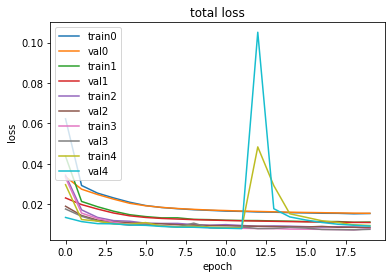

In [46]:
legend = []

for i in range(len(history)):
  plt.plot(history[i])
  legend.append('train' + str(i))

  plt.plot(historyTest[i])
  legend.append('val' + str(i))

plt.title('total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.savefig('second_training.png')
plt.show()

<h3>Avaliação dos resultados obtidos</h3>

In [47]:
encoded_imgs = []
decoded_imgs = []

for i in range(len(encoder)):
  encoded_imgs.append(encoder[i](test_images).numpy())
  decoded_imgs.append(decoder[i](encoded_imgs[i]).numpy())

  encoded_imgs[i] = encoded_imgs[i] * 255
  encoded_imgs[i] = encoded_imgs[i].astype('int')

  decoded_imgs[i] = decoded_imgs[i] * 255
  decoded_imgs[i] = decoded_imgs[i].astype('int')

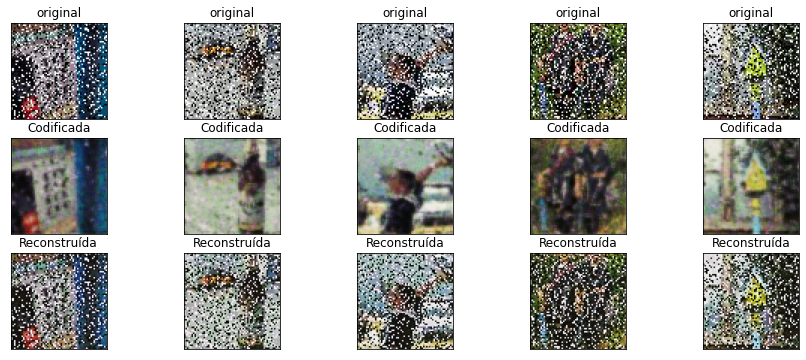

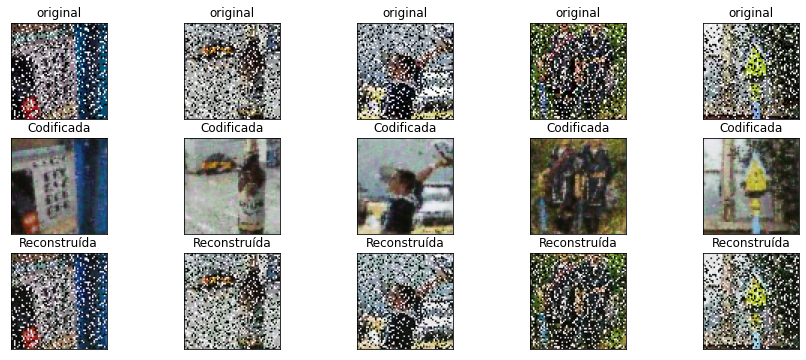

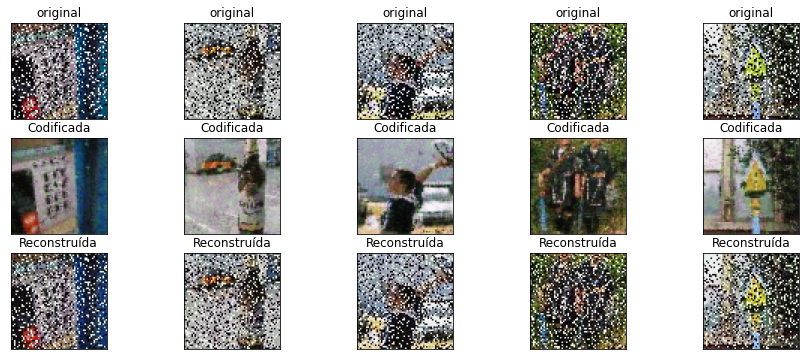

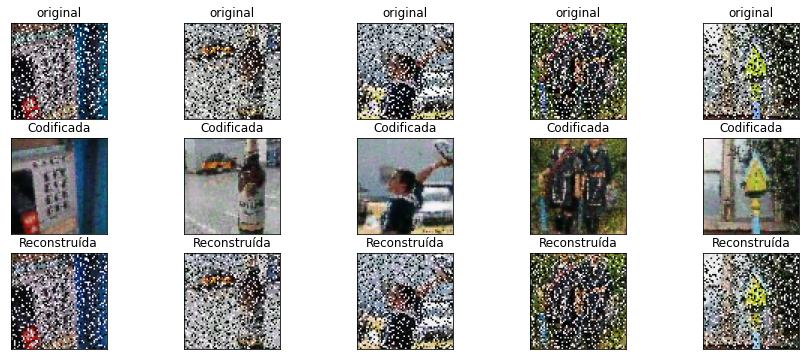

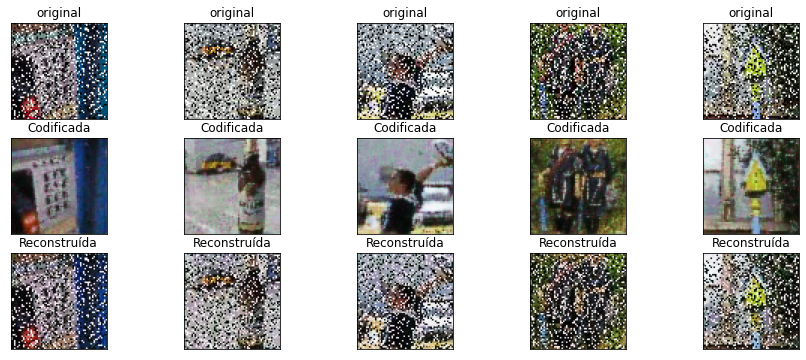

In [48]:
for k in range(len(encoder)):
  n = 5
  plt.figure(figsize=(15, 6))
  for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[k][i])
    plt.title("Codificada")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
      
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_imgs[k][i])
    plt.title("Reconstruída")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
  plt.savefig('img_results_' + str(k) + '.png')
  plt.show()

<h3>Medidas de semelhanças entre a imagem original e a imagem com a mensagem escodida</h3>

In [49]:
mseMean = []

for enc_set in encoded_imgs:
  enc_set = enc_set / 255
  mseSum = 0
  for i in range(test_images_original.shape[0]):
    mseSum += mean_squared_error(test_images_original[i], enc_set[i])
    
  mseMean.append(mseSum / test_images_original.shape[0])

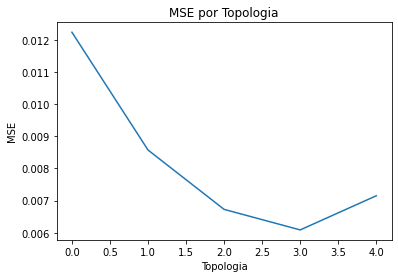

In [50]:
plt.plot(mseMean)
plt.title('MSE por Topologia')
plt.ylabel('MSE')
plt.xlabel('Topologia')
plt.savefig('mse_por_topologia.png')
plt.show()

<h3>Média de erro de bit na recuperação das mensagens secretas por topologia</h3>

In [51]:
def erroBits(x, y):
  qtd = 0

  for i in range(x.shape[0]):
    if x[i] != y[i]:
      qtd += 1

  return qtd

In [52]:
listaMediaErro = []

for k in range(len(encoder)):
  mediaErro = 0

  j = 0

  for i in decoded_imgs[k]:
      a = np.array(i, copy=True)
      msgA = steganoInv(a)
      idxBitErro = corrigeHammerArray(msgA, nHammer)
      if idxBitErro > 0 and idxBitErro < len(msgA):
        msgA[idxBitErro - 1] = ~msgA[idxBitErro - 1] & 1
      
      erroValor = erroBits(test_messages[j], msgA)

      mediaErro += erroValor

      j += 1

  mediaErro /= decoded_imgs[k].shape[0]

  listaMediaErro.append(mediaErro)

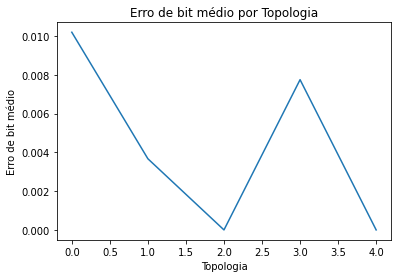

In [53]:
plt.plot(listaMediaErro)
plt.title('Erro de bit médio por Topologia')
plt.ylabel('Erro de bit médio')
plt.xlabel('Topologia')
plt.savefig('erro_de_bit_medio_por_topologia.png')
plt.show()